## Lab 1

#### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_curve, auc, accuracy_score

SEED = 1234
SPLIT_RATIO = 0.2

### Q1

__Regression__. In this exercise, we will use linear regression for estimating the number of
hours a person would be absent from work given their available information. For this,
we use the “absenteesim at work” dataset obtained from the UCI repository, which is
attached to the assignment in Canvas. In the dataset, you will find information about
individuals, such as their age, education, reasons for absence, etc., as well as the target
variable, which is absenteesim time in hours.

- (a) How many data points does the dataset include? How many features does each
data point have?

- (b) Randomly split the data into train and test with the ratio 80/20, that is, use 80%
of the data to fit the line, and the remaining 20% for testing, with the pre-specified
random seed. Train a linear regression model on the training data. Then, use the
trained model to estimate hours of absence in the test data. Report the average
root mean squared error (RMSE) on the test data.

- (c) Perform 10-fold cross validation and report the RMSE obtained from each fold as
well as their average.

- (d) How does the result in (b) compare to the result in (c)? Based on your analysis,
does it suffice to avoid using cross-validation and simply train and test with a
random split of the data? Interpret.

#### (a)

In [2]:
absent_df = pd.read_csv('Absenteeism_at_work.csv', sep=',')
print('The dataset includes {} data points.\n Each data point has {} features.'
      .format(len(absent_df), absent_df.columns.size))

The dataset includes 740 data points.
 Each data point has 21 features.


#### (b)

In [3]:
class Model(object):
    def __init__(self, X=None, y=None):
        self.seed = SEED
        self.split_ratio = SPLIT_RATIO
        self.model = None
        self.X = X
        self.y = y

    def simple_split(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                            self.y,
                                                            test_size=self.split_ratio,
                                                            random_state=self.seed)
        return X_train, X_test, y_train, y_test

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def loss(self, X_train, X_test, y_train, y_test):
        return NotImplemented

    def cross_val_evaluate(self, fold=None, cross_val=False):
        return NotImplemented
    

class LinearRegressionModel(Model):
    def __init__(self):
        super(LinearRegressionModel, self).__init__(X=absent_df.iloc[:, :-1],
                                                    y=absent_df.iloc[:, -1])
        self.model = LinearRegression(fit_intercept=True, normalize=True)

    def fit(self, X_train, y_train):
        super(LinearRegressionModel, self).fit(X_train, y_train)

    def predict(self, X_test):
        return super(LinearRegressionModel, self).predict(X_test)

    def loss(self, X_train, X_test, y_train, y_test):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        return np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))

    def cross_val_evaluate(self, fold=None, cross_val=False):
        if not cross_val:
            X_train, X_test, y_train, y_test = self.simple_split()
            return self.loss(X_train, X_test, y_train, y_test)
        else:
            rmse_lst = []
            skf = StratifiedKFold(n_splits=fold, random_state=self.seed, shuffle=True)
            for train_index, test_index in skf.split(self.X, self.y):
                X_train, X_test, y_train, y_test = self.X.iloc[train_index, :], self.X.iloc[test_index, :], self.y[train_index], self.y[test_index]
                rmse = self.loss(X_train, X_test, y_train, y_test)
                rmse_lst.append(rmse)
            return rmse_lst, np.mean(rmse_lst)
        
lr = LinearRegressionModel()

In [4]:
print('The RMSE on the test data is {:.3f}.'.format(lr.cross_val_evaluate()))

The RMSE on the test data is 8.888.


#### (c)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


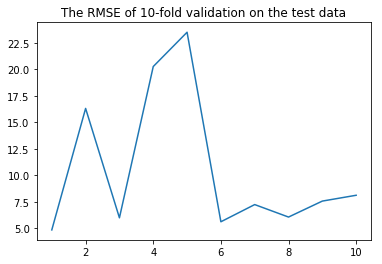

The average RMSE of the 10-fold cross validation is: 10.546.


In [5]:
rmse_lst, avg_rmse = lr.cross_val_evaluate(fold=10, cross_val=True)
plt.plot(range(1, 11), rmse_lst)
plt.title('The RMSE of 10-fold validation on the test data')
plt.show()
print('The average RMSE of the 10-fold cross validation is: {:0.3f}.'.format(avg_rmse))

#### (d)

The average RMSE of the 10-fold validation is larger than the RMSE of simple random train_test_split. No, it does not suffice to avoid using cross-validation. Because the RMSE score from simply apply a random split of the training and testing dataset is highly unstable. If we do not assign a fixed random 
seed, the RMSE would be varied in a wide range. For instance:

In [6]:
def test_random_seed(tmp_seed, model=LinearRegressionModel()):
    model.seed = tmp_seed
    X_train, X_test, y_train, y_test = model.simple_split()
    return model.loss(X_train, X_test, y_train, y_test)

In [7]:
test_random_seed(4321)

11.22598908932569

In [8]:
test_random_seed(5432)

10.707758835029146

In [9]:
test_random_seed(6543)

17.2608274665027

In [10]:
test_random_seed(7654)

13.907089461667496

From the tests above, we can see that with different seed assigned, the outcome of RMSE oscillates 
substantially. Thus we could conclude that although with a slightly higher error when applying cross-validation, part of it actually includes the generalization error.

### Q2

__K Nearest Neighbors (KNN) Classification__. Bob, our collaborator at Penn
State Hershey Medical School is interested in predicting whether a cell is cancerous
or not. Specifically, he is researching on the Breast Cancer dataset in which each cell
is represented by a feature vector of its characteristics such as its size, etc., and is
1
classified as being benign, or malignant. Load the Breast Cancer dataset from sklearn
datasets.

- (a) How many data points does the dataset include? How many features does each
data point have?
- (b) Randomly split the data into train and test with the ratio 80/20, that is, use 80%
of the data to fit the line, and the remaining 20% for testing, with the pre-specified
random seed. Train a 5 nearest neighbor classifier on the training data. Then,
use the trained model on the test data and report the area under the ROC curve
(AUC).
- (c) Perform 5-fold cross validation. Plot the ROC curve of each fold and compute
the AUC of each fold. Then, report the average AUC of all 5 folds. Compare
the obtained AUCs. Does it suffice to stick with the strategy in item (b), or is it
more meaningful to perform cross validation? Please explain.

#### (a)

In [11]:
X, y = load_breast_cancer(return_X_y=True)
print('The dataset includes {} data points.\n Each data point has {} features.'
      .format(X.shape[0], X.shape[1]))

The dataset includes 569 data points.
 Each data point has 30 features.


#### (b)

In [12]:
class KNNClassifier(Model):
    def __init__(self):
        super(KNNClassifier, self).__init__(X=load_breast_cancer().data,
                                            y=load_breast_cancer().target)
        self.model = KNeighborsClassifier(n_neighbors=5)

    def fit(self, X_train, y_train):
        return super(KNNClassifier, self).fit(X_train, y_train)

    def predict(self, X_test):
        return super(KNNClassifier, self).predict(X_test)

    def loss(self, X_train, X_test, y_train, y_test):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        auc_value = auc(fpr, tpr)
        return fpr, tpr, auc_value

    def plot_roc(self, fpr, tpr, auc_value, fold=None):
        plt.figure()
        plt.plot(fpr, tpr, color='red',
                 lw=2, label='ROC curve (area = %0.3f)' % auc_value)
        plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if fold != None:
            plt.title('ROC plot of fold {}, auc = {}'.format(fold, auc_value))
        else:
            plt.title('ROC plot, auc = {}'.format(auc_value))
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def cross_val_evaluate(self, fold=None, cross_val=False):
        if not cross_val:
            X_train, X_test, y_train, y_test = self.simple_split()
            _, _, auc_value = self.loss(X_train, X_test, y_train, y_test)
            return auc_value
        else:
            auc_lst = []
            skf = StratifiedKFold(n_splits=fold, random_state=self.seed, shuffle=True)
            fold = 1
            for train_index, test_index in skf.split(self.X, self.y):
                X_train, X_test, y_train, y_test = self.X[train_index, :], self.X[test_index, :], self.y[train_index], self.y[test_index]
                fpr, tpr, auc_value = self.loss(X_train, X_test, y_train, y_test)
                self.plot_roc(fpr, tpr, auc_value, fold=fold)
                auc_lst.append(auc_value)
                fold += 1
            return auc_lst, np.mean(auc_lst)
        
knn_classify = KNNClassifier()

In [13]:
print('The AUC on the test data is {:.3f}.'.format(knn_classify.cross_val_evaluate()))

The AUC on the test data is 0.927.


#### (c)

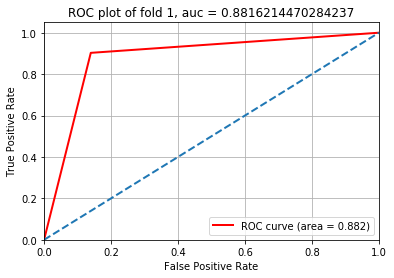

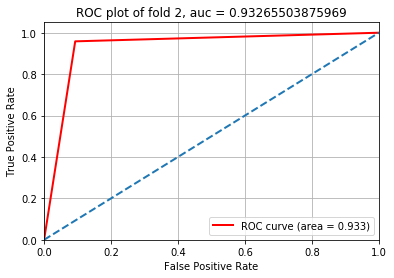

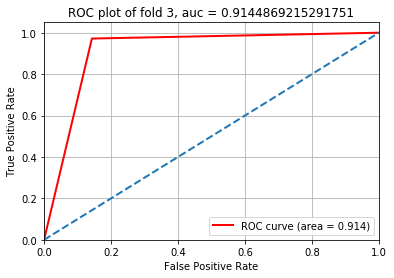

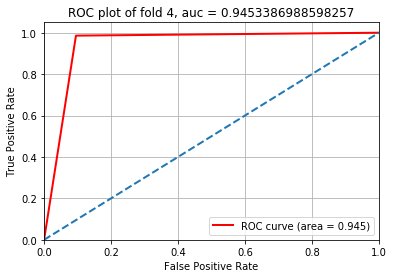

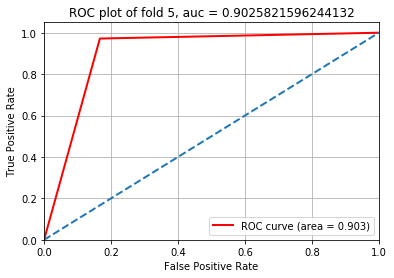

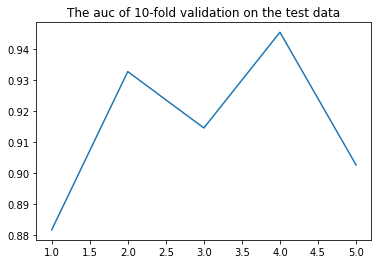

The average auc of the 10-fold cross validation is: 0.9153368531603056.


In [14]:
auc_lst, avg_auc = knn_classify.cross_val_evaluate(fold=5, cross_val=True)
plt.plot(range(1, 6), auc_lst)
plt.title('The auc of 10-fold validation on the test data')
plt.show()
print('The average auc of the 10-fold cross validation is: {}.'.format(avg_auc))

Similar as what we explore in Q1 part (c), it is
more meaningful to perform cross validation even though the average auc is slightly lower (depends on the ransom seed), because it includes generalization error when doing cross validation.

In [15]:
_, _, auc_value = test_random_seed(4321, model=KNNClassifier())
auc_value

0.9299050114641336

In [16]:
_, _, auc_value = test_random_seed(5432, model=KNNClassifier())
auc_value

0.9315476190476191

In [17]:
_, _, auc_value = test_random_seed(6543, model=KNNClassifier())
auc_value

0.8787878787878788

In [18]:
_, _, auc_value = test_random_seed(7654, model=KNNClassifier())
auc_value

0.954871794871795

### Q3

__K Neighbors Regression__. Return to the dataset in Problem 1. This time, we are
interested in K neighbors regression instead of a regression on the whole dataset and we
would like to analyze what would be reasonable number of neighbors and what distance
to use based on the data. To do so, __perform 10-fold cross validation__. In each fold, fit a
“weighted” linear regression in the following manner: For a given test data point, we
would like to estimate its outcome based on its $k \in \{1, . . . , 10\}$ nearest neighbors and
a regression line weighted by the inverse of the distance of the neighbors of the test
point. We would like to use the Minkowski distance with degree p ∈ {1, . . . , 10}. For
each fold, report the k and p at which we obtain the lowest RMSE. Do you get the
same k and p from each fold? If yes, what does this mean? If no, why not? Then,
report the average RMSE across all folds. How different is this obtained RMSE than
the one you obtained from Problem 1? Explain.

In [19]:
class KNNRegressionModel(Model):
    def __init__(self,
                 dist='minkowski',
                 weights='distance',
                 max_k=10,
                 max_p=10):
        super(KNNRegressionModel, self).__init__(X=absent_df.iloc[:, :-1],
                                                 y=absent_df.iloc[:, -1])
        self.dist = dist
        self.weights = weights
        self.max_k = max_k
        self.max_p = max_p
        self.model = None

    def knn_regression_model(self, k, p):
        return KNeighborsRegressor(n_neighbors=k,
                                   weights=self.weights,
                                   metric=self.dist,
                                   p=p)

    def fit(self, X_train, y_train):
        return super(KNNRegressionModel, self).fit(X_train, y_train)

    def predict(self, X_test):
        return super(KNNRegressionModel, self).predict(X_test)

    def loss(self, X_train, X_test, y_train, y_test):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        return np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))

    def cross_val_evaluate(self, fold=10, cross_val=True):
        fold_lst = []
        k_lst = []
        p_lst = []
        rmse_lst = []
        skf = StratifiedKFold(n_splits=fold, random_state=self.seed, shuffle=True)
        fold = 1
        for train_index, test_index in skf.split(self.X, self.y):
            X_train, X_test, y_train, y_test = self.X.iloc[train_index, :], self.X.iloc[test_index, :], self.y[train_index], self.y[test_index]
            for k in range(1, self.max_k + 1):
                for p in range(1, self.max_p + 1):
                    self.model = self.knn_regression_model(k, p)
                    rmse = self.loss(X_train, X_test, y_train, y_test)
                    fold_lst.append(fold)
                    k_lst.append(k)
                    p_lst.append(p)
                    rmse_lst.append(rmse)
            fold += 1
        df = pd.DataFrame({
            'fold': fold_lst,
            'k': k_lst,
            'p': p_lst,
            'rmse': rmse_lst
        })

        min_rmse_indexes = df.groupby(by=df['fold']).apply(lambda x: x.rmse.values.argmin())
        min_rmse_df = pd.DataFrame(
            df[df.fold == fold].iloc[min_rmse_indexes[fold], :] for fold in range(1, len(min_rmse_indexes) + 1))
        return df, min_rmse_df
    
knn_reg = KNNRegressionModel()

In [20]:
df, min_rmse_df = knn_reg.cross_val_evaluate(fold=10, cross_val=True)
min_rmse_df

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


,fold,k,p,rmse
90,1.0,10.0,1.0,6.706570
139,2.0,4.0,10.0,18.728864
242,3.0,5.0,3.0,4.478503
330,4.0,4.0,1.0,20.478647
406,5.0,1.0,7.0,22.327933
591,6.0,10.0,2.0,5.655086
630,7.0,4.0,1.0,7.008642
799,8.0,10.0,10.0,8.217983
883,9.0,9.0,4.0,8.053388
999,10.0,10.0,10.0,12.369984


Most of the k and p are from each fold with the min RMSE are not the same.
The difference of k in the 10-fold cross validation is affected by the random split of the dataset in each fold, causing slightly different distribution of the training and testing set. And regarding the difference of p in each fold, probably because the the optimal value for choosing k and corresponding p will depend on the
bias-variance tradeoff.

In [21]:
df.rmse.mean(), min_rmse_df.rmse.mean()

(12.947155142792509, 11.402560014845626)

In Problem 1, the average RMSE of the 10-fold cross validation is: 10.546, while here the average RMSE across all folds is 11.402(average of the min RMSE across all folds, if it is the average of the all RMSE across all folds, then is 12.947), the difference is small but RMSE increases, indicates that the linear regression model, as a parametric approach preforms slightly better than KNN regression, the non parametric approach in this case. Therefore, there's possibility that the feature set of the absent work dataset might be more likely to be linearly related to the absent time.